### Imports

In [15]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, make_scorer,mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


### Dataframe

In [26]:
df = pd.read_csv('laptopPrice.csv')

In [17]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [27]:
#drop Number of Ratings and Number of Reviews
df.drop(['Number of Ratings', 'Number of Reviews'], axis=1, inplace=True)

In [31]:
#check missing values
df.isnull().sum()

brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
os                 0
os_bit             0
graphic_card_gb    0
weight             0
warranty           0
Touchscreen        0
msoffice           0
Price              0
rating             0
Total_Storage      0
Processor_Tier     0
Log_Price          0
dtype: int64

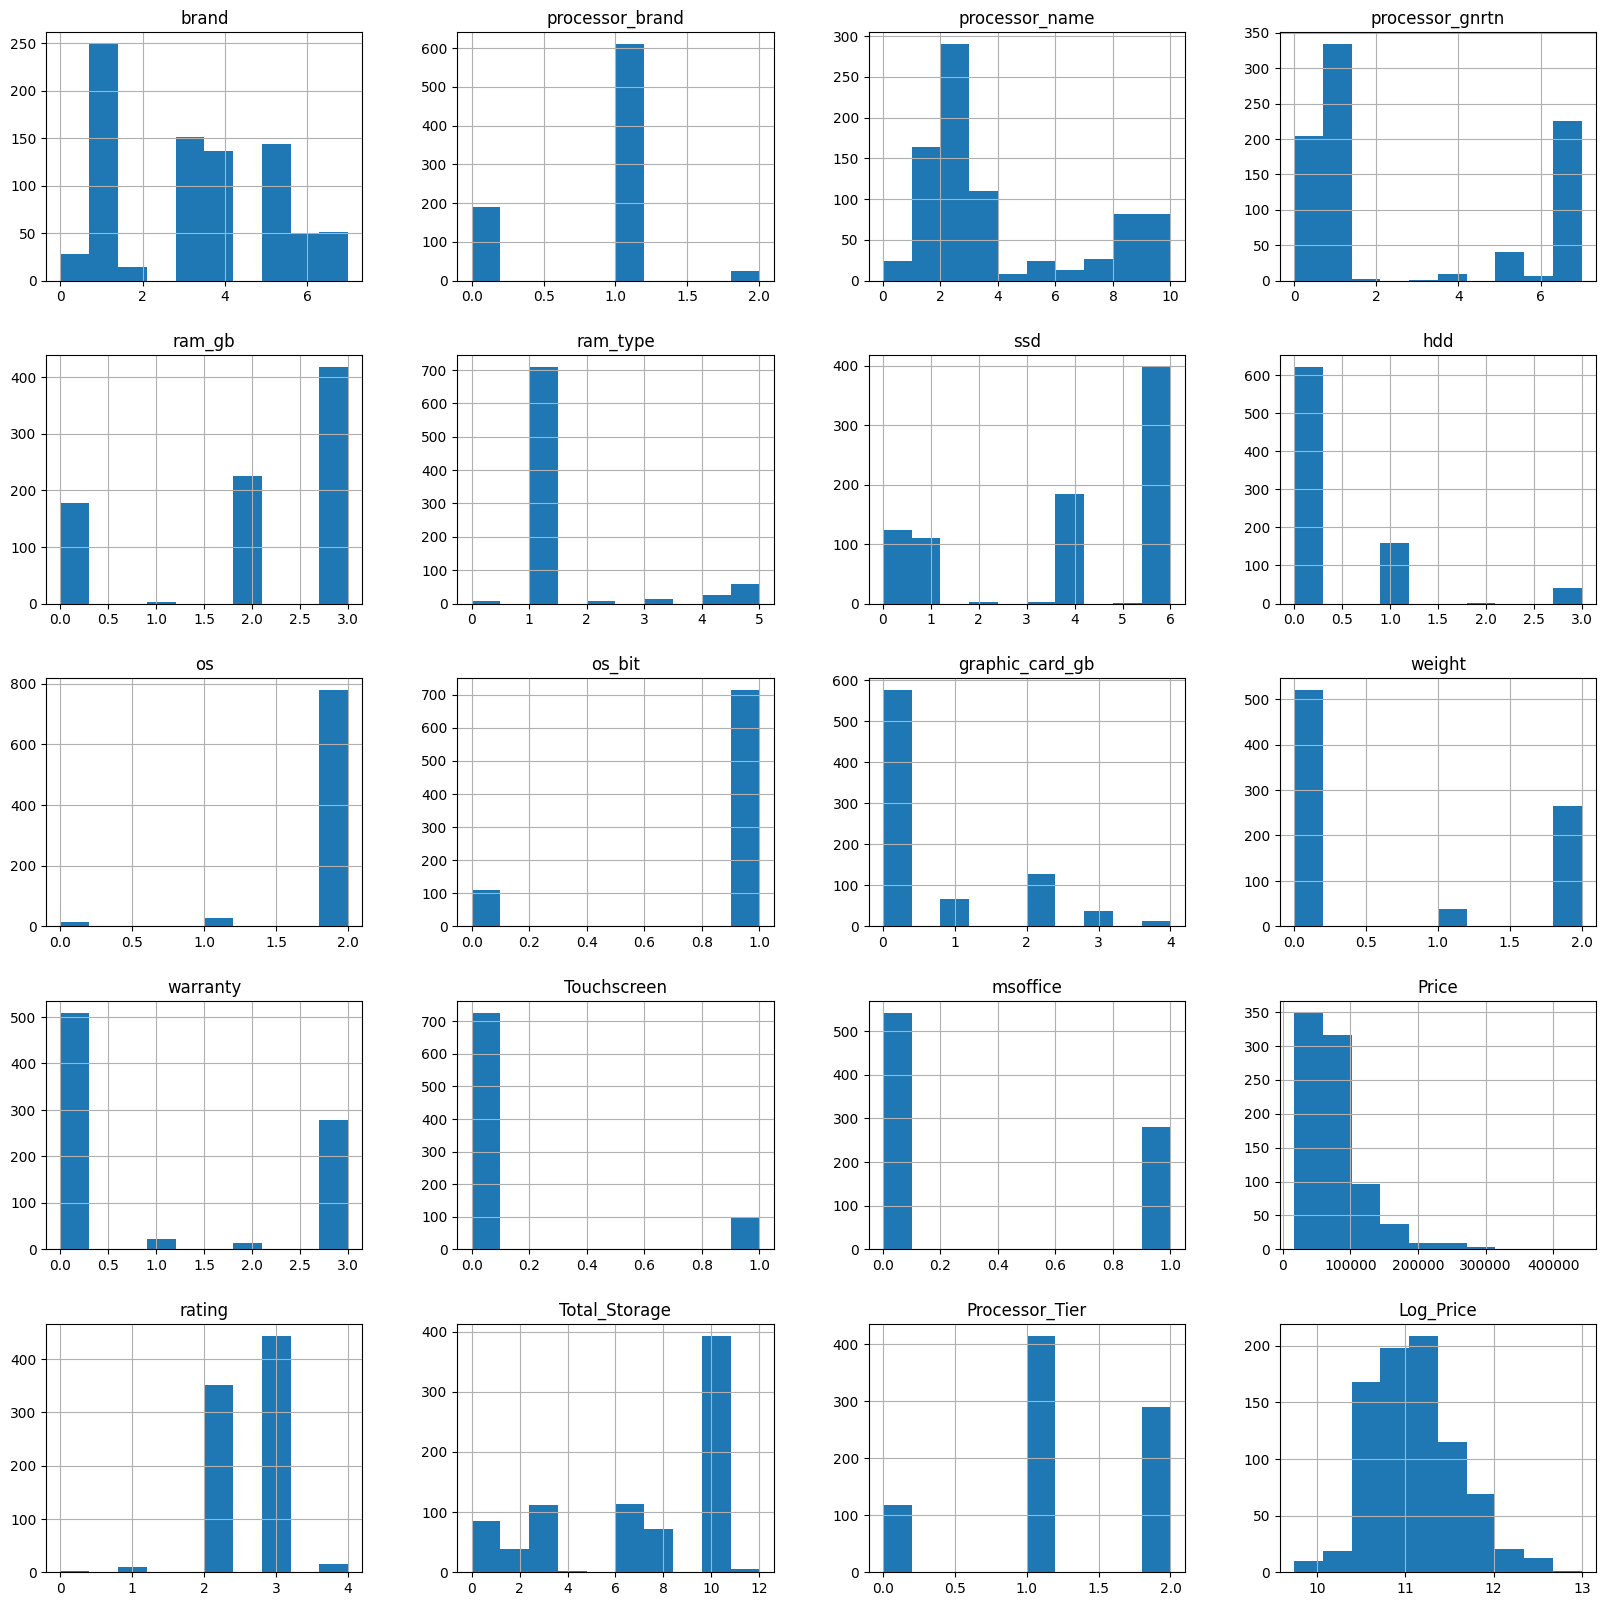

In [44]:
#visualize the data 
df.hist(figsize=(20,20))
plt.show()


### Feature Engineering

In [29]:
# Feature Engineering
df['Total_Storage'] = df['ssd'] + df['hdd']
df['Processor_Tier'] = df['processor_name'].apply(lambda x: 'High' if 'i7' in x or 'i9' in x else ('Medium' if 'i5' in x else 'Low'))
df['Log_Price'] = np.log1p(df['Price'])


### Pre Processing

In [30]:
# Separate categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

In [ ]:
'''# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
train_data_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))
train_data_encoded.columns = train_data_encoded.columns.astype(str)
df = pd.concat([df, train_data_encoded], axis=1)
df = df.drop(categorical_columns, axis=1)'''

In [33]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Total_Storage,Processor_Tier,Log_Price
0,1,1,1,0,2,1,0,1,2,1,0,0,3,0,0,34649,1,0,1,10.453053
1,5,1,1,0,2,1,0,1,2,1,0,0,3,0,0,38999,2,0,1,10.571317
2,5,1,1,0,2,1,0,1,2,1,0,0,3,0,0,39999,2,0,1,10.596635
3,1,1,2,0,3,1,6,0,2,0,1,0,3,0,0,69990,2,10,2,11.156122
4,1,1,0,7,2,1,0,3,2,1,0,0,3,0,0,26990,2,2,1,10.203259


In [32]:
#Apply Label Encoding to the categorical columns
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [36]:
#split the data into features and target
X = df.drop('Price', axis=1)
y = df['Price']

### Scaling

In [35]:
#Apply MinMaxScale
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Split

In [37]:
poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)  
X = poly.fit_transform(X)

#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models

In [ ]:
'''#apply regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)'''

In [ ]:
'''model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.2, min_samples_split=4, min_samples_leaf=3, max_features='sqrt')

model.fit(X_train, y_train)'''

### Optuna Search

In [ ]:
'''#apply optuna for random forest
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = int(trial.suggest_int('max_depth', 1, 32, log=True))
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)'''

In [38]:
#apply optuna for xgboost
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    return score

In [39]:
#start optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

#get best parameters
best_params = study.best_params
best_params

[I 2024-06-23 22:09:06,288] A new study created in memory with name: no-name-a06cfda2-a4e6-411d-8b46-00ffc90a23bf
[I 2024-06-23 22:09:06,831] Trial 0 finished with value: 463586920.5779421 and parameters: {'n_estimators': 744, 'max_depth': 4, 'learning_rate': 0.013951679564468447, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.00016195837038136964, 'reg_alpha': 5.489102449807063e-06, 'reg_lambda': 3.127590293017736e-07, 'min_child_weight': 180}. Best is trial 0 with value: 463586920.5779421.
[I 2024-06-23 22:09:07,187] Trial 1 finished with value: 412700424.6120069 and parameters: {'n_estimators': 902, 'max_depth': 7, 'learning_rate': 0.12171430622534092, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.04868631307127232, 'reg_alpha': 0.000261425444530329, 'reg_lambda': 0.05869988412883626, 'min_child_weight': 225}. Best is trial 1 with value: 412700424.6120069.
[I 2024-06-23 22:09:07,445] Trial 2 finished with value: 173304889.59462035 and parameters: {'n_estimators': 525,

{'n_estimators': 380,
 'max_depth': 9,
 'learning_rate': 0.11534280402188352,
 'subsample': 0.8,
 'colsample_bytree': 0.7,
 'gamma': 1.7358777674082673e-07,
 'reg_alpha': 0.00894754778155815,
 'reg_lambda': 2.1343107230312103e-06,
 'min_child_weight': 3}

In [40]:
#apply xgboost model
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
'''#random forest regressor
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)'''

### Results

In [41]:
#calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error: ", mse)

#calculate R2 score
r2 = model.score(X_test, y_test)
print("R2 Score: ", r2)

#calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

#compare the values with the actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)


R2 Score:  0.9984763533403672
Root Mean Squared Error:  1723.16371157693
     Actual      Predicted
610  104990  104992.804688
174   41890   41786.070312
67    41998   41970.476562
168   40390   40148.863281
275   57500   57385.195312
..      ...            ...
290   77990   78267.867188
211  136590  136136.421875
448   55490   55526.402344
766   73138   73197.335938
526  162399  171097.031250

[165 rows x 2 columns]


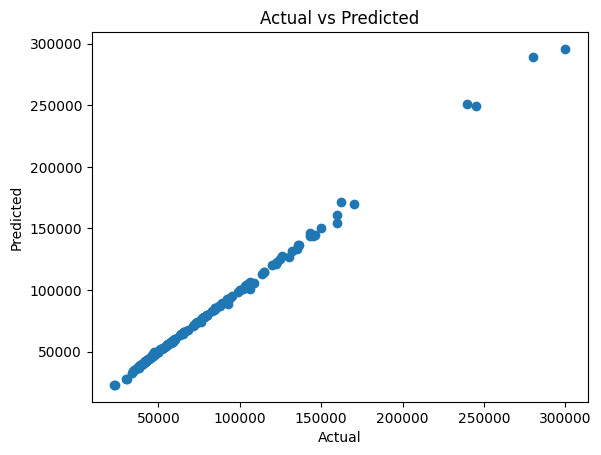

In [42]:
#plot the comparison
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [43]:
#output price and predicted price in a csv file 
comparison.to_csv('LaptopPrice_Predicitons.csv', index=False)
